# Qulacsの最低限の使い方&変分アルゴリズムの構成

In [1]:
from qulacs import ParametricQuantumCircuit
import scipy.optimize

import matplotlib.pyplot as plt
import numpy as np
import time 
import random
import scipy.linalg

from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer

from qulacs import QuantumState
#固定ゲート
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算

#パラメータ付きゲート
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import U1,U2,U3 #IBM Gate
from qulacs.gate import PauliRotation




from qulacs import Observable

In [2]:
def show_observable(hamiltonian):
    for j in range(hamiltonian.get_term_count()):
        pauli=hamiltonian.get_term(j)

        # Get the subscript of each pauli symbol
        index_list = pauli.get_index_list()

        # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
        pauli_id_list = pauli.get_pauli_id_list()

        # Get pauli coefficient
        coef = pauli.get_coef()

        # Create a copy of pauli operator
        another_pauli = pauli.copy()

        s = ["I","X","Y","Z"]
        pauli_str = [s[i] for i in pauli_id_list]
        terms_str = [item[0]+str(item[1]) for item in zip(pauli_str,index_list)]
        full_str = str(coef) + " " + " ".join(terms_str)
        print(full_str)


def define_Heisenberg_Hamiltonian(operator,ListOfInt):
    nqubits = operator.get_qubit_count()
    for k in range(len(ListOfInt)):
        operator.add_operator(1.0,"Z {0}".format(ListOfInt[k][0])+"Z {0}".format(ListOfInt[k][1]))
        operator.add_operator(1.0,"X {0}".format(ListOfInt[k][0])+"X {0}".format(ListOfInt[k][1])) 
        operator.add_operator(1.0,"Y {0}".format(ListOfInt[k][0])+"Y {0}".format(ListOfInt[k][1])) 
    return operator



def define_Z_field(operator):
    nqubits = operator.get_qubit_count()
    for k in range(nqubits):
        operator.add_operator(1.0,"Z {0}".format(k)) 
    return operator



def hamiltonian_ansatz(hamiltonian,driver,max_depth):
    i=0

    nqubits = hamiltonian.get_qubit_count()
    ansatz_circuit =ParametricQuantumCircuit(nqubits)


    for depth in range(max_depth):
        for j in range(hamiltonian.get_term_count()):
            pauli = hamiltonian.get_term(j)

            # Get the subscript of each pauli symbol
            index_list = pauli.get_index_list()

            # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
            pauli_id_list = pauli.get_pauli_id_list()

            ansatz_circuit.add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, 0.0)
            i+=1

        for j in range(driver.get_term_count()):
            pauli = driver.get_term(j)

            # Get the subscript of each pauli symbol
            index_list = pauli.get_index_list()
            # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
            pauli_id_list = pauli.get_pauli_id_list()

            ansatz_circuit.add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, 0.0)
            i+=1    
 #   print(ansatz_circuit.get_parameter_count())
#    print(ansatz_circuit)
    return ansatz_circuit

def cost_func_ansatz(ansatz_circuit,hamiltonian,para):
    nqubits = ansatz_circuit.get_qubit_count()
    state = QuantumState(nqubits)

    parameter_count = ansatz_circuit.get_parameter_count()



    for i in range(parameter_count):
        ansatz_circuit.set_parameter(i,para[i])
        
    ansatz_circuit.update_quantum_state(state)

    return  hamiltonian.get_expectation_value(state)



In [3]:
nqubits = 3
state = QuantumState(nqubits)
print(state)
state.get_vector()

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
(1,0)
(0,0)
(0,0)
(0,0)
(0,0)
(0,0)
(0,0)
(0,0)



array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [4]:
my_vector = [ 1.1 for i in range(8)]
my_vector

[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]

In [5]:
state.load(my_vector)
print(state)

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
(1.1,0)
(1.1,0)
(1.1,0)
(1.1,0)
(1.1,0)
(1.1,0)
(1.1,0)
(1.1,0)



In [6]:
state.set_zero_state()
print(state)

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
(1,0)
(0,0)
(0,0)
(0,0)
(0,0)
(0,0)
(0,0)
(0,0)



In [7]:
state.set_Haar_random_state()
print(state)

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
(0.0172775,-0.0380851)
 (-0.0124971,0.283042)
  (0.526546,-0.293042)
   (0.338521,0.456432)
  (0.0368478,0.287595)
 (-0.107395,-0.298935)
  (0.157371,0.0942958)
(-0.0593572,0.0989268)



In [8]:
circuit = QuantumCircuit(nqubits)
print(circuit)

*** Quantum Circuit Info ***
# of qubit: 3
# of step : 0
# of gate : 0
Clifford  : yes
Gaussian  : yes




In [9]:
state.set_zero_state()
circuit = QuantumCircuit(nqubits)

for i in range(nqubits):
    circuit.add_gate(H(i))
print(circuit)

circuit.update_quantum_state(state)
print(state)

*** Quantum Circuit Info ***
# of qubit: 3
# of step : 1
# of gate : 3
# of 1 qubit gate: 3
Clifford  : yes
Gaussian  : no


 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
(0.353553,0)
(0.353553,0)
(0.353553,0)
(0.353553,0)
(0.353553,0)
(0.353553,0)
(0.353553,0)
(0.353553,0)



In [10]:
nqubits =10
state = QuantumState(nqubits)
state.set_Haar_random_state()
circuit = QuantumCircuit(nqubits)

for i in range(nqubits):
    circuit.add_gate(H(i))
print(circuit)

circuit.update_quantum_state(state)

*** Quantum Circuit Info ***
# of qubit: 10
# of step : 1
# of gate : 10
# of 1 qubit gate: 10
Clifford  : yes
Gaussian  : no




In [11]:
measurement = Observable(nqubits)
measurement.add_operator(1.0,"Z 0")
show_observable(measurement)

(1+0j) Z0


In [12]:
measurement.add_operator(1.5,"Z 1")
show_observable(measurement)

(1+0j) Z0
(1.5+0j) Z1


In [13]:
measurement.add_operator(1.5,"Y 2")
show_observable(measurement)

(1+0j) Z0
(1.5+0j) Z1
(1.5+0j) Y2


In [14]:
measurement.add_operator(1.5,"Z 0 X 1")
show_observable(measurement)

(1+0j) Z0
(1.5+0j) Z1
(1.5+0j) Y2
(1.5+0j) Z0 X1


In [15]:
measurement.get_expectation_value(state)

-0.09720225856010761

In [16]:
state.sampling(10)

[358, 903, 624, 23, 664, 581, 117, 268, 485, 457]

In [17]:
nqubits = 3

hamiltonian = Observable(nqubits)
hamiltonian = define_Heisenberg_Hamiltonian(hamiltonian,[[0,1],[1,2],[2,0]])
show_observable(hamiltonian)
driver = Observable(nqubits)
driver = define_Z_field(driver)

(1+0j) Z0 Z1
(1+0j) X0 X1
(1+0j) Y0 Y1
(1+0j) Z1 Z2
(1+0j) X1 X2
(1+0j) Y1 Y2
(1+0j) Z2 Z0
(1+0j) X2 X0
(1+0j) Y2 Y0


In [18]:
max_depth =2
ansatz_circuit = hamiltonian_ansatz(hamiltonian,driver,max_depth)

def cost(para):
    return cost_func_ansatz(ansatz_circuit,hamiltonian,para)


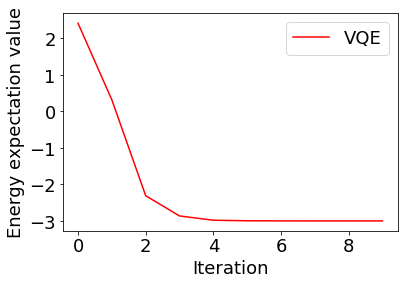

In [19]:
cost_history = []
init_theta_list = [random.random() for i in range(ansatz_circuit.get_parameter_count())]
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

In [20]:
def open_square_Heisenberg_anti_ferro(length):
    nqubits = length**2
    
    vertical = [[i,(i+1)%length] for i in range(length-1)]
    horizontal = [[(i%length)*length,((i+1)%length)*length] for i in range(length-1)]

    ListOfInt = []
    for pair in vertical:
        for i in range(length):
            ListOfInt.append([pair[0]+i*length,pair[1]+i*length])

    for pair in horizontal:
        for i in range(length):
            ListOfInt.append([pair[0]+i,pair[1]+i])

#    print(ListOfInt)
    
    hamiltonian = Observable(nqubits)
    hamiltonian = define_Heisenberg_Hamiltonian(hamiltonian,ListOfInt)

    return hamiltonian

In [25]:
max_depth =2
length = 3
hamiltonian = open_square_Heisenberg_anti_ferro(length)
ansatz_circuit = hamiltonian_ansatz(hamiltonian,driver,max_depth)

def cost(para):
    return cost_func_ansatz(ansatz_circuit,hamiltonian,para)

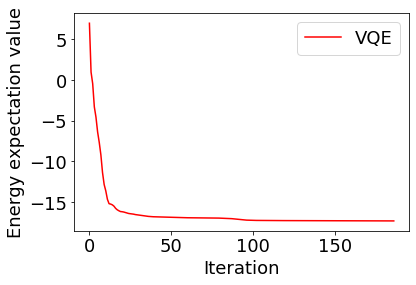

In [26]:
cost_history = []
init_theta_list = [random.random() for i in range(ansatz_circuit.get_parameter_count())]
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 10, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()